### 1. Import packages and artifacts

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                             classification_report, confusion_matrix)
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("Dataset/preprocessed_train dataset.csv")

encoders = joblib.load("label_encoders.pkl")
Label_Encoded_columns = joblib.load("Label_Encoded_columns.pkl")
OneHot_Encoded_columns = joblib.load("OneHot_Encoded_columns.pkl")
target_encoder = encoders["Credit_Score"]

### 2. Train-Val Split

In [4]:
X_train = df_train.drop("Credit_Score", axis=1)
numerical_cols = [col for col in X_train.columns if col not in OneHot_Encoded_columns + Label_Encoded_columns]

scaler = StandardScaler()

# scale only the numerical columns
X_train.loc[:, numerical_cols] = scaler.fit_transform(X_train[numerical_cols])


y_train = df_train["Credit_Score"]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

y_train_decoded= target_encoder.inverse_transform(y_train)
y_val_decoded= target_encoder.inverse_transform(y_val)

C:\Users\ARIF\AppData\Local\Temp\ipykernel_19344\3154294692.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.23642452  1.51367809 -1.11147582 ...  0.20110114  0.63862679
 -0.23642452]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_cols] = scaler.fit_transform(X_train[numerical_cols])


### 3. Develop Model

### A. Random Forest Classifier (RFC)

In [5]:
RFC = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid_RFC = { "n_estimators": [100, 200],
               "max_depth": [10, None],
               "min_samples_split": [2, 5],
               "min_samples_leaf": [1, 3]}


grid_search_RFC = GridSearchCV(estimator=RFC,
                           param_grid=param_grid_RFC,
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           scoring="accuracy")

grid_search_RFC.fit(X_train, y_train)
print("Best Parameters:", grid_search_RFC.best_params_)
print("Best CV Score:", grid_search_RFC.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.7450394310939811


RFC Validation accuracy:  0.7723660839487707
RFC Validation recall:  0.7723757727454005
RFC Validation precision:  0.7703956945993528
RFC Validation F1 score:  0.7691803628884762


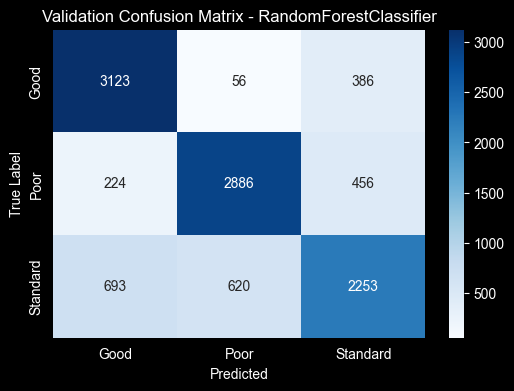

Validation target class distribution: 


Standard    3566
Poor        3566
Good        3565
Name: count, dtype: int64

In [6]:
best_model_RFC = grid_search_RFC.best_estimator_
y_pred_RFC = best_model_RFC.predict(X_val)
y_pred_RFC = target_encoder.inverse_transform(y_pred_RFC)

cm_RFC = confusion_matrix(y_val_decoded, y_pred_RFC)
RFC_acc = accuracy_score(y_val_decoded, y_pred_RFC)
RFC_recall = recall_score(y_val_decoded, y_pred_RFC, average='macro')
RFC_precision = precision_score(y_val_decoded, y_pred_RFC, average='macro')
RFC_F1_score = f1_score(y_val_decoded, y_pred_RFC, average='macro')


print("RFC Validation accuracy: ", RFC_acc)
print("RFC Validation recall: ", RFC_recall)
print("RFC Validation precision: ", RFC_precision)
print("RFC Validation F1 score: ", RFC_F1_score)

# Set up the figure
plt.figure(figsize=(6,4))
sns.heatmap(cm_RFC, annot=True, fmt='d', cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title("Validation Confusion Matrix - RandomForestClassifier")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()

print("Validation target class distribution: ")
pd.Series(y_val_decoded).value_counts()

### B. K-nearest Neighbor (KNN) Classifier

In [7]:
# Define model
KNN= KNeighborsClassifier()

param_grid_KNN = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

grid_search_KNN = GridSearchCV(estimator=KNN,
                               param_grid=param_grid_KNN,
                               cv=3,
                               n_jobs=-1,
                               verbose=1,
                               scoring="accuracy")

grid_search_KNN.fit(X_train, y_train)

print("Best Parameters:", grid_search_KNN.best_params_)
print("Best CV Score:", grid_search_KNN.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best CV Score: 0.666697799466093


KNN Validation accuracy:  0.6925306160605778
KNN Validation recall:  0.6925408715684492
KNN Validation precision:  0.6868933609075608
KNN Validation F1 score:  0.6866827240226997


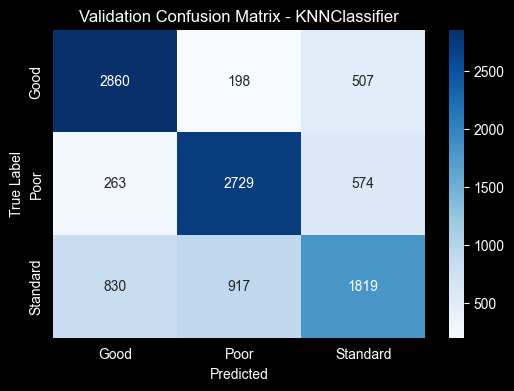

Validation target class distribution: 


Standard    3566
Poor        3566
Good        3565
Name: count, dtype: int64

In [8]:
best_model_KNN = grid_search_KNN.best_estimator_
y_pred_KNN = best_model_KNN.predict(X_val)
y_pred_KNN = target_encoder.inverse_transform(y_pred_KNN)

cm_KNN = confusion_matrix(y_val_decoded, y_pred_KNN)
KNN_acc = accuracy_score(y_val_decoded, y_pred_KNN)
KNN_recall = recall_score(y_val_decoded, y_pred_KNN, average='macro')
KNN_precision = precision_score(y_val_decoded, y_pred_KNN, average='macro')
KNN_F1_score = f1_score(y_val_decoded, y_pred_KNN, average='macro')


print("KNN Validation accuracy: ", KNN_acc)
print("KNN Validation recall: ", KNN_recall)
print("KNN Validation precision: ", KNN_precision)
print("KNN Validation F1 score: ", KNN_F1_score)

# Set up the figure
plt.figure(figsize=(6,4))
sns.heatmap(cm_KNN, annot=True, fmt='d', cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title("Validation Confusion Matrix - KNNClassifier")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()

print("Validation target class distribution: ")
pd.Series(y_val_decoded).value_counts()

### C. LightGBM

In [9]:
LGBM = LGBMClassifier(random_state=42)

param_grid_LGBM = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "learning_rate": [0.01, 0.1],
    "num_leaves": [50, 100]
}

grid_search_LGBM  = GridSearchCV(
    estimator=LGBM,
    param_grid=param_grid_LGBM ,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy"
)

grid_search_LGBM .fit(X_train, y_train)
print("Best Parameters (LightGBM):", grid_search_LGBM .best_params_)
print("Best CV Score (LightGBM):", grid_search_LGBM .best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 42787, number of used features: 13
[LightGBM] [Info] Start training from score -1.098566
[LightGBM] [Info] Start training from score -1.098636
[LightGBM] [Info] Start training from score -1.098636
Best Parameters (LightGBM): {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 100}
Best CV Score (LightGBM): 0.7412064917243567


LGBM Validation accuracy:  0.7573151350846031
LGBM Validation recall:  0.7573256277077389
LGBM Validation precision:  0.7539492431984719
LGBM Validation F1 score:  0.7536207959260978


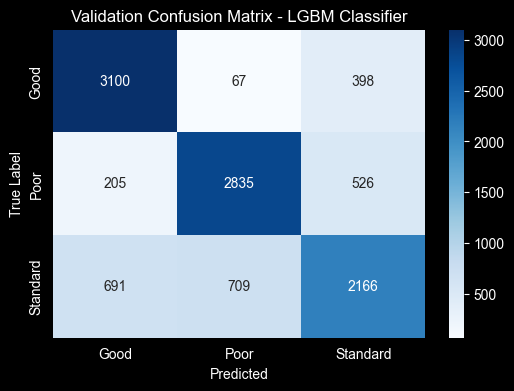

Validation target class distribution: 


Standard    3566
Poor        3566
Good        3565
Name: count, dtype: int64

In [10]:
best_model_LGBM  = grid_search_LGBM.best_estimator_
y_pred_LGBM = best_model_LGBM.predict(X_val)
y_pred_LGBM = target_encoder.inverse_transform(y_pred_LGBM)

cm_LGBM = confusion_matrix(y_val_decoded, y_pred_LGBM)
LGBM_acc = accuracy_score(y_val_decoded, y_pred_LGBM)
LGBM_recall = recall_score(y_val_decoded, y_pred_LGBM, average='macro')
LGBM_precision = precision_score(y_val_decoded, y_pred_LGBM, average='macro')
LGBM_F1_score = f1_score(y_val_decoded, y_pred_LGBM, average='macro')

print("LGBM Validation accuracy: ", LGBM_acc)
print("LGBM Validation recall: ", LGBM_recall)
print("LGBM Validation precision: ", LGBM_precision)
print("LGBM Validation F1 score: ", LGBM_F1_score)

# Set up the figure
plt.figure(figsize=(6,4))
sns.heatmap(cm_LGBM, annot=True, fmt='d', cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title("Validation Confusion Matrix - LGBM Classifier")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()

print("Validation target class distribution: ")
pd.Series(y_val_decoded).value_counts()

### D. XGBoost

In [11]:
XGB = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

param_grid_XGB = {
    "n_estimators": [100, 200],
    "max_depth": [6, 10],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search_XGB = GridSearchCV(
    estimator=XGB,
    param_grid=param_grid_XGB,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy"
)

grid_search_XGB.fit(X_train, y_train)
print("Best Parameters (XGBoost):", grid_search_XGB.best_params_)
print("Best CV Score (XGBoost):", grid_search_XGB.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Data\Kaggle Credit Score Classification\.venv\lib\site-packages\xgboost\training.py:199: UserWarning: [10:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score (XGBoost): 0.7477738655553808


XGB Validation accuracy:  0.7677853603814153
XGB Validation recall:  0.7677961590912249
XGB Validation precision:  0.764876664107852
XGB Validation F1 score:  0.7640435708875479


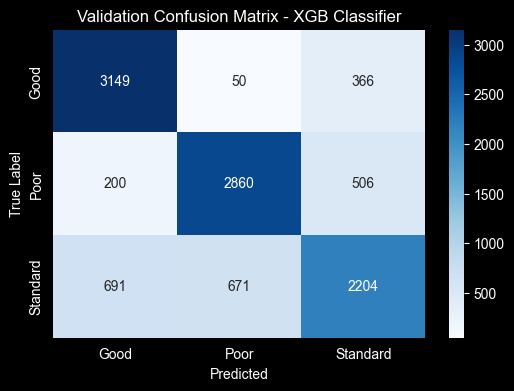

Validation target class distribution: 


Standard    3566
Poor        3566
Good        3565
Name: count, dtype: int64

In [12]:
best_model_XGB = grid_search_XGB.best_estimator_
y_pred_XGB = best_model_XGB.predict(X_val)
y_pred_XGB = target_encoder.inverse_transform(y_pred_XGB)

cm_XGB = confusion_matrix(y_val_decoded, y_pred_XGB)
XGB_acc = accuracy_score(y_val_decoded, y_pred_XGB)
XGB_recall = recall_score(y_val_decoded, y_pred_XGB, average='macro')
XGB_precision = precision_score(y_val_decoded, y_pred_XGB, average='macro')
XGB_F1_score = f1_score(y_val_decoded, y_pred_XGB, average='macro')

print("XGB Validation accuracy: ", XGB_acc)
print("XGB Validation recall: ", XGB_recall)
print("XGB Validation precision: ", XGB_precision)
print("XGB Validation F1 score: ", XGB_F1_score)

# Set up the figure
plt.figure(figsize=(6,4))
sns.heatmap(cm_XGB, annot=True, fmt='d', cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title("Validation Confusion Matrix - XGB Classifier")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()

print("Validation target class distribution: ")
pd.Series(y_val_decoded).value_counts()

### 5. Deep Neural Network (DNN) Classifier

Epoch 1/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5973 - loss: 0.8584 - val_accuracy: 0.6152 - val_loss: 0.8360
Epoch 2/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6214 - loss: 0.8222 - val_accuracy: 0.6232 - val_loss: 0.8207
Epoch 3/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6302 - loss: 0.8093 - val_accuracy: 0.6273 - val_loss: 0.8104
Epoch 4/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6376 - loss: 0.7987 - val_accuracy: 0.6403 - val_loss: 0.8034
Epoch 5/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6426 - loss: 0.7906 - val_accuracy: 0.6395 - val_loss: 0.7990
Epoch 6/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6452 - loss: 0.7819 - val_accuracy: 0.6435 - val_loss: 0.7980
Epoch 7/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6483 - loss: 0.7752 - val_accuracy: 0.6465 - val_loss: 0.7938
Epoch 8/400
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6545 - loss:

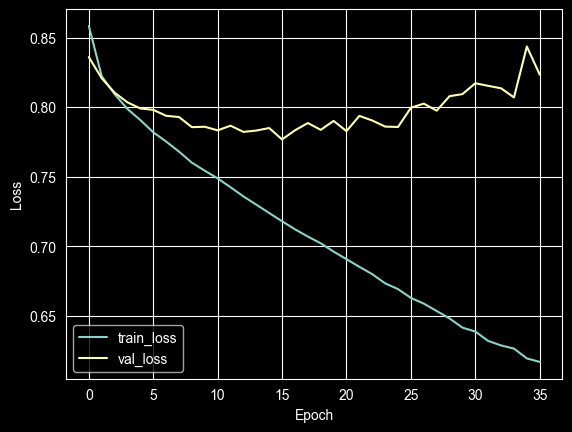

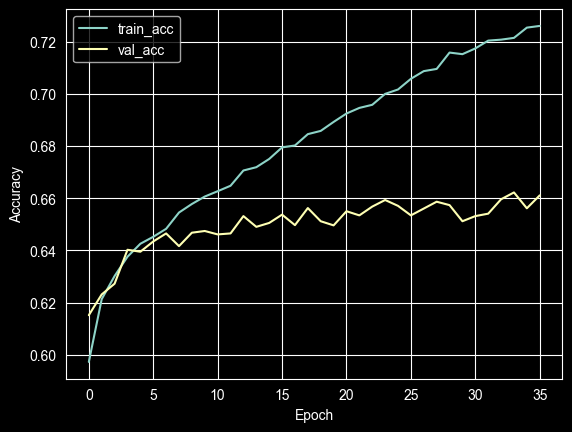

In [13]:
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(target_encoder.classes_), activation='softmax')(x)

model_DNN = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_DNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model_DNN.fit(X_train, y_train,
                    epochs=400, batch_size=32,
                    validation_data = (X_val, y_val),
                    callbacks=[early_stop])


# Plot training & validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DNN Validation accuracy:  0.6537346919697111
DNN Validation recall:  0.6537460830129866
DNN Validation precision:  0.646112288478451
DNN Validation F1 score:  0.6447222850160372


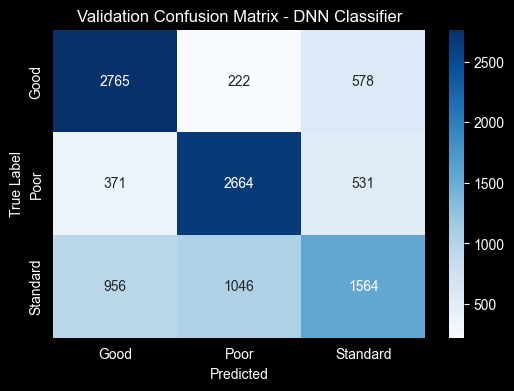

Validation target class distribution: 


Standard    3566
Poor        3566
Good        3565
Name: count, dtype: int64

In [14]:
y_pred_DNN = np.argmax(model_DNN.predict(X_val), axis = 1)
y_pred_DNN = target_encoder.inverse_transform(y_pred_DNN)

cm_DNN = confusion_matrix(y_val_decoded, y_pred_DNN)
DNN_acc = accuracy_score(y_val_decoded, y_pred_DNN)
DNN_recall = recall_score(y_val_decoded, y_pred_DNN, average='macro')
DNN_precision = precision_score(y_val_decoded, y_pred_DNN, average='macro')
DNN_F1_score = f1_score(y_val_decoded, y_pred_DNN, average='macro')

print("DNN Validation accuracy: ", DNN_acc)
print("DNN Validation recall: ", DNN_recall)
print("DNN Validation precision: ", DNN_precision)
print("DNN Validation F1 score: ", DNN_F1_score)

# Set up the figure
plt.figure(figsize=(6,4))
sns.heatmap(cm_DNN, annot=True, fmt='d', cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title("Validation Confusion Matrix - DNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()

print("Validation target class distribution: ")
pd.Series(y_val_decoded).value_counts()

### Save models

In [15]:
joblib.dump(scaler, "standard_scaler.pkl")
joblib.dump(best_model_RFC, "Saved Models/model_RFC.pkl")
joblib.dump(best_model_KNN, "Saved Models/model_KNN.pkl")
joblib.dump(best_model_XGB, "Saved Models/model_XGB.pkl")
joblib.dump(best_model_LGBM, "Saved Models/model_LGBM.pkl")
model_DNN.save("Saved Models/model_DNN.keras")

# load models:
# model_x = joblib.load("Saved Models/model_x.pkl")

# from tensorflow.keras.models import load_model
# model_DNN = load_model("Saved Models/model_DNN.keras")